In [1]:
! ls

capstone			    README.md
capstone2.py			    trial2-load-explore-dl.ipynb
config.yml			    trial3-competition-df-dl.ipynb
connect-storage-bucket-trial.ipynb  trial4-atelectasis.ipynb
data				    trial-data-exploration.ipynb
initial-load-exploration-dl.ipynb


In [2]:
! ls data

CheXpert-v1.0-small  models


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
gcp_path = os.getcwd()
gcp_path

'/home/jupyter/springboard-capstone-2'

In [7]:
! mv ~/.fastai ~/.fastai-old

In [8]:
!ln -s /home/jupyter/springboard-capstone-2 ~/.fastai

In [6]:
path = Config.data_path()
# path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [7]:
train_df = pd.read_csv(path/'CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv(path/'CheXpert-v1.0-small/valid.csv')

print(train_df.shape)
print(valid_df.shape)

(223414, 19)
(234, 19)


# Prepare Data

In [8]:
# extract patient id and add to columns
train_df['Patient_id'] = train_df.Path.str.split('/', 3, True)[2]
valid_df['Patient_id'] = valid_df.Path.str.split('/', 3, True)[2]

In [9]:
# primary pathological targets of CheXpert paper
competition_tasks = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

competition_tasks

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

### Create seed and sample_df functions

In [10]:
def seed_data(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [11]:
def sample_df(sample_perc = 0.05):
    unique_patients = train_df['Patient_id'].unique() # unique observations from patient column
    mask = np.random.rand(len(unique_patients)) <= sample_perc # random mask the same length as # of unqiue patients
    sample_patients = unique_patients[mask] # patients sampled according to mask
    
    sample_df = train_df[train_df['Patient_id'].isin(sample_patients)]
    return sample_df

In [12]:
seed_data(1)

In [13]:
sample_df = sample_df()

In [14]:
sample_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient_id
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003
44,CheXpert-v1.0-small/train/patient00015/study1/...,Female,76,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,patient00015
45,CheXpert-v1.0-small/train/patient00015/study2/...,Female,76,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,patient00015
93,CheXpert-v1.0-small/train/patient00028/study1/...,Male,70,Frontal,PA,NaN,0.0,NaN,-1.0,NaN,NaN,0.0,NaN,-1.0,0.0,0.0,NaN,NaN,NaN,patient00028
94,CheXpert-v1.0-small/train/patient00028/study2/...,Male,71,Frontal,AP,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,patient00028


# Baseline Atelectasis Model (utilizing _U-Ones_ Uncertainty Model)

In [15]:
task = 'Atelectasis'
train_sample_atel = sample_df[['Path', task]].fillna(0).reset_index(drop=True)
valid_atel = valid_df[['Path', task]].fillna(0).reset_index(drop=True)

In [16]:
train_sample_atel.head(5)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00003/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00015/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00015/study2/...,-1.0
3,CheXpert-v1.0-small/train/patient00028/study1/...,-1.0
4,CheXpert-v1.0-small/train/patient00028/study2/...,1.0


In [17]:
train_sample_atel.shape

(11576, 2)

In [18]:
train_sample_atel['Atelectasis'].value_counts(normalize=True)

 0.0    0.698601
 1.0    0.152903
-1.0    0.148497
Name: Atelectasis, dtype: float64

In [19]:
valid_atel.head(5)

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


In [20]:
valid_atel.shape

(234, 2)

In [21]:
valid_atel['Atelectasis'].value_counts(normalize=True)

0.0    0.65812
1.0    0.34188
Name: Atelectasis, dtype: float64

In [22]:
# reassign -1 to 1 
train_atel = train_sample_atel.replace(to_replace=-1.0, value=1)
train_atel[task] = train_atel[task].astype(int)

In [23]:
train_atel['Atelectasis'].value_counts(normalize=True)

0    0.698601
1    0.301399
Name: Atelectasis, dtype: float64

In [24]:
# save training df for atelectasis
train_atel.to_csv('data/train_atel.csv')

In [28]:
# if restarting kernel due to memory issues, uncomment below and load df from here
#train_atel_testrun = pd.read_csv(path/'train_atel.csv')[['Path', 'Atelectasis']]
#train_atel_testrun

In [29]:
tfms = get_transforms(True, False, max_rotate=None, max_zoom=0., max_lighting=0.3,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])

In [30]:
src = (ImageList.from_df(df=train_atel, path=path, folder='.', suffix=''))

In [31]:
src = src.split_by_rand_pct(0.2)

In [30]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = 32)
        .normalize(imagenet_stats))

In [31]:
# treat 5-radiologist voted validation data as test
data.add_test(ImageList.from_df(valid_atel, path=path, folder='.', suffix=''))

In [32]:
data.c

2

In [33]:
data.classes

[0, 1]

In [34]:
data

ImageDataBunch;

Train: LabelList (9261 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (2315 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/springboard-capstone-2/data

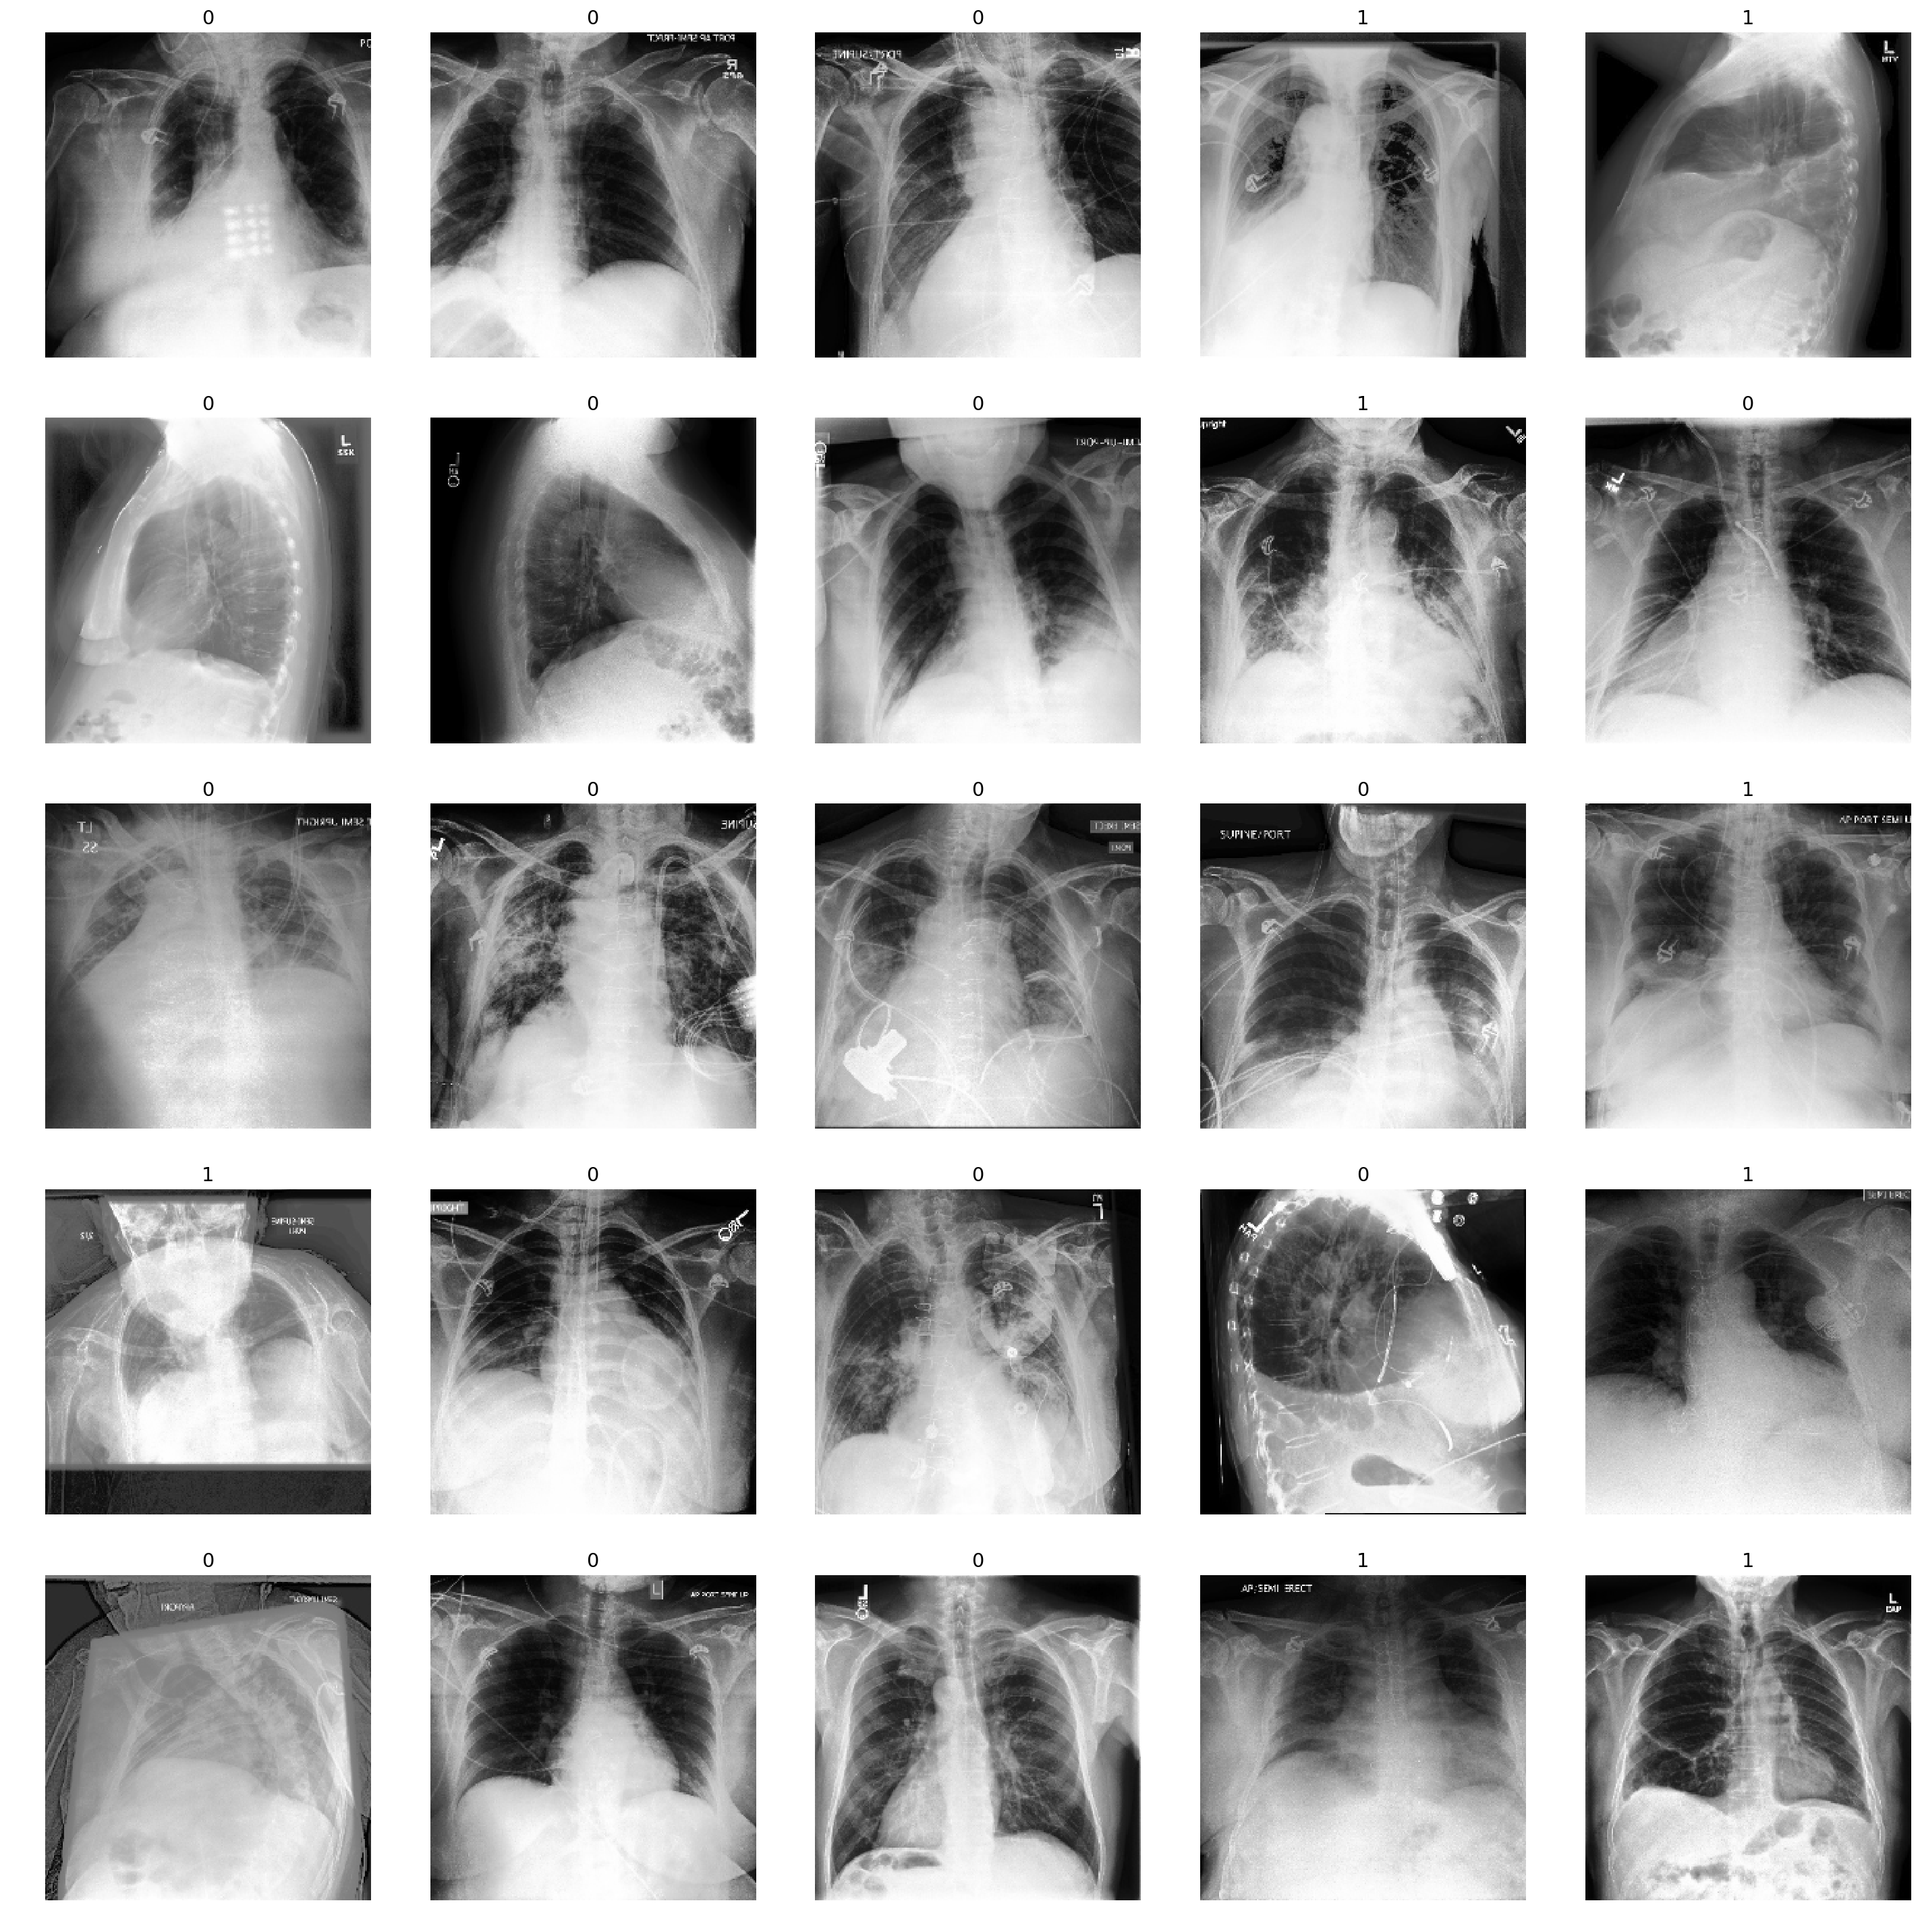

In [35]:
data.show_batch()

# Baseline DL Model

In [ ]:
# torch.cuda.empty_cache() 

In [ ]:
# 1/0

In [ ]:
# assert False, "please liberate my GPU!"

In [37]:
from sklearn.metrics import roc_auc_score

class AUC(Callback):
    "AUC score"
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.outputs = []
        self.targets = []

    def on_batch_end(self, last_output, last_target, **kwargs):
        "expects binary output with data.c=2 "
        self.outputs += list(to_np(last_output)[:, 1])
        self.targets += list(to_np(last_target))

    def on_epoch_end(self, last_metrics, **kwargs): 
        return {'last_metrics': last_metrics + [roc_auc_score(self.targets, self.outputs)]}
auc = AUC()

In [37]:
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc])

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02


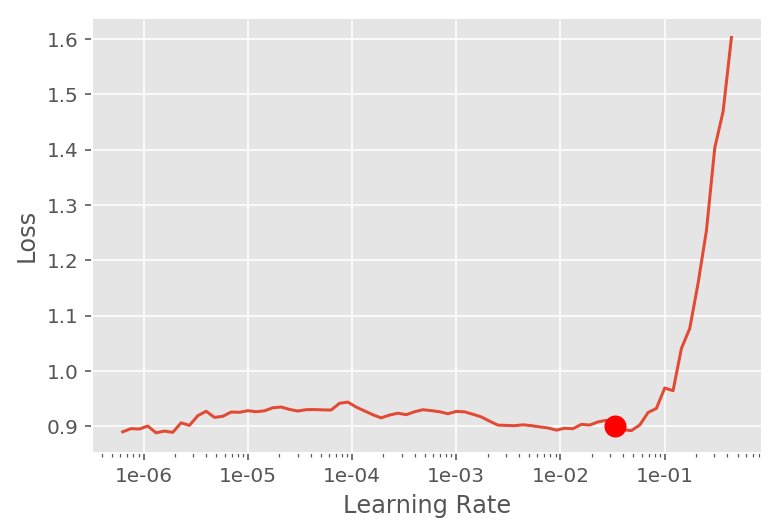

In [39]:
learn.recorder.plot(suggestion=True)

In [40]:
lr = 3.31e-2

In [41]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.779409,0.850068,0.702808,0.540296,01:54
1,0.666788,0.667808,0.631965,0.452192,01:51
2,0.637773,0.642968,0.702808,0.521331,01:51
3,0.603074,0.615341,0.702808,0.572875,01:51
4,0.597035,0.592502,0.702808,0.603738,01:51


In [42]:
learn.save('atelectasis-stage-1-dn121')

### Fine-tune model

In [43]:
learn.unfreeze()

Min numerical gradient: 1.44E-03


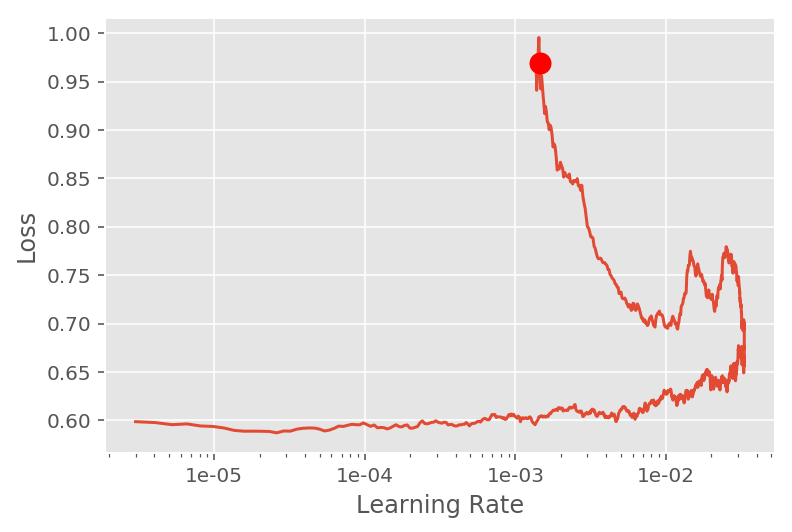

In [44]:
learn.recorder.plot(suggestion=True)

In [45]:
lr = 1.44e-3

In [46]:
learn.fit_one_cycle(5, slice(1e-3, lr/5))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.601331,0.743358,0.692009,0.544478,02:22
1,0.603801,0.764301,0.702808,0.509259,02:21
2,0.609032,0.604420,0.702808,0.575054,02:21
3,0.601181,0.598720,0.702808,0.588236,02:21
4,0.602365,0.595246,0.702808,0.596510,02:21


In [47]:
learn.save('atelectasis-stage-2-dn121')

# Restarting and Loading Model `atelectasis-stage-2-dn121`

In [33]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=8
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 7601MB of GPU RAM free


In [34]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [38]:
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc])

In [39]:
learn.load('atelectasis-stage-2-dn121')

Learner(data=ImageDataBunch;

Train: LabelList (9261 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,1,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (2315 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,1,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [52]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [40]:
learn.data = data # replace original data in learner with new data of size=256
data.train_ds[0][0].shape

torch.Size([3, 320, 320])

In [50]:
#learn.freeze() # allows us to train last few layers

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


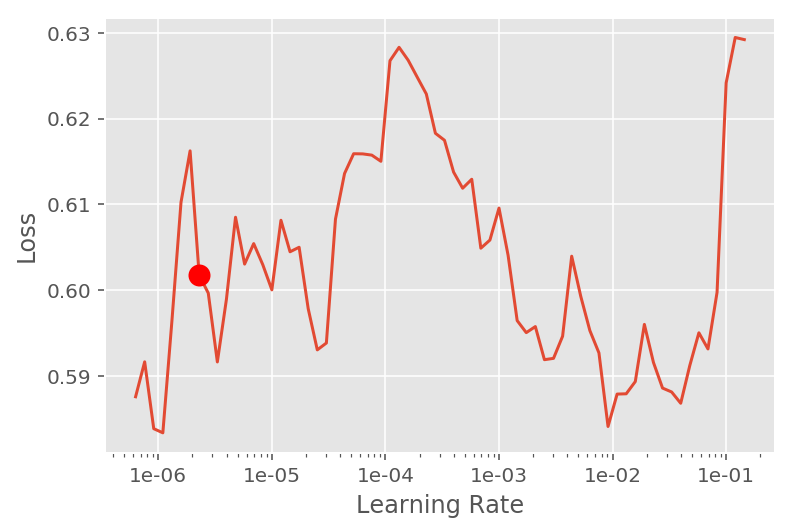

In [41]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [43]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.613271,0.597427,0.702376,0.598919,04:14
1,0.580087,0.593581,0.702808,0.602479,04:11
2,0.606652,0.597120,0.702808,0.607101,04:11


In [44]:
learn.save('atelectasis-stage-2-dn121')